# GRAPPA student seminar: Indirect detection - J-factors

by Paul Hofland, Bouke Jung and Iris de Ruiter

In [1]:
# Import all libraries
from __future__ import division
import numpy as np
import pylab as plt
import scipy.optimize as op
from scipy.integrate import odeint
from scipy.integrate import nquad
%matplotlib inline

In [2]:
# kpc in cm
kpc_to_cm = 3.086e+21 #cm

# (Astro)Physical constants
c = 2.9979e10 #cm s-1
eV = 1.60217662e-12 # erg
Msol = 1.9885e33 #g


# The Hubble scale parm and critical density of the universe as given in:
# http://pdg.lbl.gov/2013/reviews/rpp2013-rev-astrophysical-constants.pdf
h = 0.673 # --
rho0_crit = 1.87847e-29 * h**2 #g cm-3
rho0_crit *= (c**2 / eV * 1e-9) #GeV cm-3 



# The density profiles 

In this section we define four dark matter density profiles. $\rho_0$ is the central dark matter density of the observed object. $r_s$ is the scale radius. The most well-known profile is the Navarro-Frenk-White (NFW) profile:

$\rho_{NFW} = \frac{\rho_0}{\left(\frac{r}{r_s}\right) \left[ 1 + \left(\frac{r}{r_s}\right) \right]^2}$


Generalizing equation the NFW profile and allowing for an arbitrary inner slope $\gamma$, we get the Generalized NFW profile:

$\rho_{GNFW} = \frac{\rho_0}{\left(\frac{r}{r_s}\right)^{\gamma} \left[ 1 + \left(\frac{r}{r_s}\right) \right]^{3-\gamma}}$

Contrary to the above two profiles, more recent simulations seem to suggest that galactic dark matter density profiles deviate from simple power-law dependencies, displaying slopes that vary with radius instead (Navarro et al. (2004), Gao et al. (2008) and Navarro et al. (2010)). One of the first attempts at modeling such irregularity was made by Einasto, who used the formula:
            
$\rho_{Ein} (r) = \rho_0 \exp \left({-\frac{2}{a} \left[ \left(\frac{r}{r_s}\right)^a - 1 \right] }\right)$


Finally we introduce the Burkert profile, which is extremely suitable for dwarf spheriodal galaxies.

$\rho_{Burk} (r) = \frac{\rho_0}{\left(1+\frac{r}{r_s}\right)\left(1+\left(\frac{r}{r_s}\right)^2\right)}$

In [3]:
# Density profiles that return either the density (square=False) 
# or density squared (square=True)

def DM_density_NFW(r, rho_0, r_s, square=False):
    rho = rho_0 / ((r / r_s) * (1 + (r / r_s))**2 )
    if (square!=True):
        return rho
    else:
        return rho**2
    
def DM_density_BURK(r, rho_0, r_s, square=False):
    rho =  rho_0 / ((1 + r / r_s) * (1 + (r / r_s )**2))
    if (square!=True):
        return rho
    else:
        return rho**2
    
def DM_density_EIN(r, rho_0, r_s, a, square=False):
    rho = rho_0 * np.exp(-(2 / a) * ((r/r_s)**a - 1))
    if (square!=True):
        return rho
    else:
        return rho**2

def DM_density_GNFW(r, rho_0, r_s, gamma, square=False):
    rho = rho_0/((r/r_s)**gamma*(1+(r/r_s))**(3-gamma))
    if (square!=True):
        return rho
    else:
        return rho**2
    
    
# General DM density function, where TYPE represents the density profile
# rho_0 is the central density in GeV/cm^3, r_s is the scale radius in cm
# gamma plays a role in the GNFW profile,
# a plays a role in the Einasto profile and
# squared can be used to return either the density or the density squared
def DM_density(TYPE, r, rho_0, r_s, gamma=1, a=1, square=False):
    if ((TYPE=="NFW") or (TYPE=="nfw")):
        return DM_density_NFW(r, rho_0, r_s, square)
    elif ((TYPE=="Burk") or (TYPE=="Burkert") or (TYPE=="BURK")):
        return DM_density_BURK(r, rho_0, r_s, square)
    elif ((TYPE=="Ein") or (TYPE=="EIN") or (TYPE=="Einasto")):
        return DM_density_EIN(r, rho_0, r_s, a, square)
    elif ((TYPE=="GNFW") or (TYPE=="gnfw")):
        return DM_density_GNFW(r, rho_0, r_s, gamma, square)   
    else:
        print("Error: \tdensity profile TYPE was not recognized. Returned -1.")
        print("\tPlease specify either of the following profile TYPEs:")
        print("\t\t-\"NFW\" for Navarro-Frenk-White profile")
        print("\t\t-\"Burk\" for Burkert profile")
        print("\t\t-\"Ein\" for Einasto profile")
        print("\t\t-\"GNFW\" for generalized Navarro-Frenk-White profile")
        return -1
        
# Allows for computation of the dark matter density along the line of 
# sight. Parameters:
#     - l: the line of sight distance into the dark matter halo
#     - mu: the cosine of the viewing angle w.r.t. the galactic center
def DM_density_LOS(l, mu, d=8.5*kpc_to_cm, rho_0=0.471, r_s = 16*kpc_to_cm,
                   gamma=1, a=1, square=True, Type="NFW"):
    r = np.sqrt(l**2 + d**2 - 2*l*d*mu)
    return DM_density(Type, r, rho_0, r_s, gamma, a, square)      

# Plot of the density profiles 

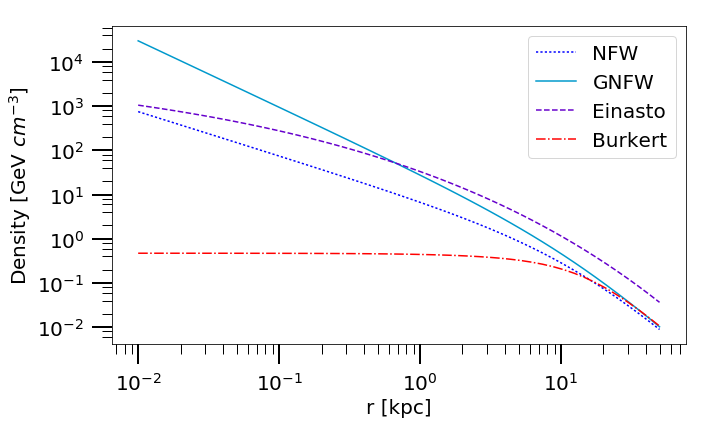

In [4]:
# Plot the density profiles for the Universe
rho_0=0.471 # GeV/cm^3
r_s=16*kpc_to_cm

#  Create a range of input radii and plot parameters
r=np.logspace(np.log10(0.01*kpc_to_cm), np.log10(50*kpc_to_cm), 50)
a_lst = [1,1,0.2,1]
gamma_lst = [1, 1.5, 1, 1]
typelst = ["NFW", "GNFW", "Einasto", "Burkert"]
colorlst = ["b","#0099cc", "#6600cc", 'r']
linestylelst = [":", "-", "--", "-."]

# Plot all density profiles
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
for i in range(4):
    density = DM_density(typelst[i], r, rho_0, r_s, gamma_lst[i], a_lst[i])
    ax.plot(r/kpc_to_cm, density, color=colorlst[i], 
            linestyle=linestylelst[i], label=typelst[i])
ax.set_xlabel(r"r [kpc]", fontsize=20)
ax.set_ylabel(r"Density [GeV $cm^{-3}}$]", fontsize=20)
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_title("Compton scattered spectrum $E_{photon,in}=$"+str(e_in))
ax.tick_params('both', labelsize=20, length=20, width=2, which='major', pad=8)
ax.tick_params('both', labelsize=20, length=10, width=1, which='minor',pad=8)
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

# J-factors for dwarf galaxies and galaxy clusters

Assuming that the central density $\rho_0$, the scale radius $r_s$ and the distance $d$ to a source are known, we can calculate its J-factor at an arbitrary observational angle $\theta$ as:

$ J = \frac{1}{\Delta\Omega}\int\int_{\Delta\Omega}^{} \rho_{DM}^2(l,\Omega)dl d\Omega $

where $\rho_{DM}(l,\Omega)$ denotes the dark matter density as a function of the line-of-sight parameter $l$ and the solid angle $\Omega$. As described in our report on indirect dark matter searches, different density profiles will have to be used for different sources. Most notably, for galaxies and galaxy clusters we can use the NFW profile:

$\rho_{NFW} = \frac{\rho_0}{\left(\frac{r}{r_s}\right) \left[ 1 + \left(\frac{r}{r_s}\right) \right]^2}$

whilst Dwarf Galaxies --- having a flat inner density profile --- are best described using a Burkert profile:

$\rho_{Burk} (r) = \frac{\rho_0}{\left(1+\frac{r}{r_s}\right)\left(1+\left(\frac{r}{r_s}\right)^2\right)}$

Here we can set:

$r = \sqrt{l^2 + d^2 - 2 l \cos{\theta}}$

via the cosine rule to rewrite the radius in terms of the line-of-sight parameter and the longitudinal angle $\theta$, which in turn allows for the integration necessary to compute the J-factor above.

In the literature one can find multiple tables that list values for $\rho_0$, $r_s$ and $d$ in the case of the Milky Way (see e.g. Boddy et al. (2018), https://arxiv.org/pdf/1805.08379.pdf) and for spheroidal dwarf galaxies (see e.g. Evans et al. (2016), https://arxiv.org/abs/1604.05599). However, most of the times, no direct values are given in the case of galaxy clusters. A paper by Hektor et al., published in 2013 (see https://arxiv.org/abs/1207.4466) lists distances $d$, virial masses $M_{vir}$ and J-factors for this is a collection of well-studied galaxy clustsers. Additionally, the paper gives values for the parameter $r_{200}$, which is typically taken to be equal to the virial radius (i.e. the radius up until which the virial theorem holds true), such that*:

$\rho(<r_{200}) = 200 \rho_c(t) = 200 \frac{3 H^2(t)}{8 \pi G}$

Using these values, we can calculate the scale radius and the scale density via the formula:

1) $r_s = r_{200} / c_{200}$

where $c_{vir}$ denotes the concentration parameter, which can be approximated via (see e.g. Storm et al. (2013) ; http://iopscience.iop.org/article/10.1088/0004-637X/768/2/106/meta):

$c_{200} = 9 \left(\frac{M_{vir}}{10^{14} M_{sol}} h\right)^{-0.172}$

and via the equation:

2) $\rho_0 = \delta_c \rho_c$

where $\rho_c \approx 5 \cdot 10^{-6}$ GeV $cm^{-3}$  denotes the critical density of the Universe and where:

$\delta_c \approx \frac{200}{3} \frac{c_{200}^3}{\ln{(1+c_{200}) - \frac{c_{200}}{1+c_{200}}}}$

signifies the overdensity associated with the cluster. The values used by us for the following analysis are listed in the files "clusters.txt" and "data.txt".

Ad *: Note that the definition of the virial radius depends on the cosmological convention which is used. For the $\Lambda$CDM model we usually take $r_{vir} = r_{200}$

In [5]:
# Function for computing the scale density (see Storm et al. (2013))
# Parameter x: x = r_s/r_vir
def delta_c(c200):
    prefact = 200./3.
    return prefact* c200**3 / (np.log(1+c200) - c200/(1+c200))

# Checks whether an object name is already specified within a file
def check_if_contained(fname, obj_name):
    with open(fname,'r') as f:
        for line in f:
            if line.startswith(obj_name):
                return True
            else:
                continue
        return False 



# Compute the galaxy cluster parameters and concatenate results to data.txt if not yet included
objnr = 0
with open("clusters.txt",'r') as cl_dataf, open("data.txt",'a') as dataf:
    for rline in cl_dataf:
        
        # Skip empty lines and comments
        if (not rline.split()) or (rline.startswith('#')):
            continue
        
        # Extract cluster name
        cl_obj = rline.split() 
        name = str(cl_obj[0])
        objnr+=1
        # Check whether cluster is contained in data.txt
        if (check_if_contained("data.txt",name)):
            continue
        
        # Extract cluster data
        Mvir = float(cl_obj[1]) #Msol
        d = float(cl_obj[2])*1e3 #kpc
        theta200 = float(cl_obj[3]) #deg
        data_j = float(cl_obj[4]) * 1e3 * kpc_to_cm * rho0_crit**2 #GeV2 cm-5
        
        # The 1-sigma errors on the J-factors
        errdata_upper_j = 0.3*np.log10(data_j)
        errdata_lower_j = 0.2*np.log10(data_j)
        
        # Compute the scale radius
        r200 = np.tan(theta200/180 * np.pi) * d #kpc
        c_vir = 9 * (Mvir * h)**(-0.172) # -- 
        r_s = r200 / c_vir #kpc # We assume r_c = r_vir for the moment
        
        # The scale density 
        deltac = delta_c(c_vir)
        rho0 = deltac * rho0_crit # GeV cm-3
        
        # A plotting colour
        pltcol = 1/(objnr+1)
        # Write the computed values to the data file
        dataf.write(name+'\t' + str(rho0)+'\t' + str(r_s)+'\t' + str(d)+'\t')
        dataf.write(str(theta200)+'\t'+str(theta200)+'\t' + str(np.log10(data_j))+'\t'+str(np.log10(data_j))+'\t')
        dataf.write(str(errdata_upper_j)+'\t'+str(errdata_upper_j)+'\t')
        dataf.write(str(errdata_lower_j)+'\t'+str(errdata_lower_j)+'\t' + str(pltcol)+'\n')
        


In [18]:
# data.txt is a txt file that contains all data for the dwarf galaxies

def plot_dwarf_galaxies(objects, profile_type, max_angle=1.5, nof_evals=20, d_factor=False):
    """Plots the J-factor and/or D-factor for the wanted objects."""
    # d_facor can be True or False, to specify whether or not it should be calculated.
    # d
    # objects is a list of object names that should be considered.
    # profile_type specifies the desired density profile.
    # max_angle is the angle up to which the J-factor is calculated/plotted.
    # nof_evals defines at how many angles the J-factor should be calculated.
    
    # Initialize plot 
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.set_yscale("log")
    
    # Compute the J-factors
    angle = np.linspace(0.01, max_angle, nof_evals) # deg
    D_factors, J_factors = np.zeros([2, 5, nof_evals])
    
    # For each object, plot the data (if available) and 
    # calculate the J-factor at the wanted angles
    for obj_name in objects:
        print("Processing " + obj_name + "...")
        # Read in data file with all paramters needed
        with open("data.txt") as f:
            for line in f:
                if line.startswith(obj_name):
                    obj = line.split()
                    rho_0 = float(obj[1])
                    r_s = float(obj[2])*kpc_to_cm
                    d = float(obj[3])*kpc_to_cm
                    data_angle = np.array([float(obj[4]), float(obj[5])])
                    data_j = np.array([float(obj[6]), float(obj[7])])
                    data_j_upper_error = np.array([float(obj[8]), float(obj[9])])
                    data_j_lower_error = np.array([float(obj[10]), float(obj[11])])
                    data_d = np.array([float(obj[12]), float(obj[13])])
                    data_d_upper_error = np.array([float(obj[14]), float(obj[15])])
                    data_d_lower_error = np.array([float(obj[16]), float(obj[17])])
                    plot_color=obj[18]

        j_ylower = 10**(data_j - data_j_lower_error)
        j_yupper = 10**(data_j + data_j_upper_error)
        d_ylower = 10**(data_d - data_d_lower_error)
        d_yupper = 10**(data_d + data_d_upper_error)

        # If all parameters are properly initialized, plot the data 
        if (data_angle[0]!=0) and (data_j[0]!=0) and (d_factor == False):
            ax.errorbar(data_angle, 10**data_j, yerr=[j_ylower, j_yupper], c=plot_color, fmt="o", label="Data "+ obj_name)
        if (data_angle[0]!=0) and (data_d[-1]!=0) and (d_factor == True):
            ax.errorbar(data_angle, 10**data_d, yerr=[d_ylower, d_yupper], c=plot_color, fmt="o", label="Data "+ obj_name)
        
        # Calculate the J-factor at each angle, using the nquad function with a relaxed stepsize
        for j, theta in enumerate(angle):
            theta *= (np.pi / 180) # Conversion to rad
            
            # Calculate the D-factor is d_factor==True
            if d_factor==True:
                D = nquad(DM_density_LOS, [[0,2*d],[np.cos(theta),1]],
                                args=(d, rho_0, r_s, 1, 1, False, profile_type), opts={"epsrel":1e-3})
                D_factors[i,j] = 2*np.pi * D[0]
            # Compute the J-factor
            else:
                J = nquad(DM_density_LOS, [[0,2*d],[np.cos(theta),1]],
                                args=(d, rho_0, r_s, 1, 1, True, profile_type),  opts={"epsrel":1e-3})
                J_factors[i,j] = 2*np.pi * J[0]
        
        # Plot the D-factor simulation results
        if d_factor==True:
            ax.plot(angle, D_factors[i], color=plot_color, linestyle="--", label="D-factor: "+ obj_name)
        # Plot the J-factor simulation
        else:
            ax.plot(angle, J_factors[i], color=plot_color, linestyle='-', label="J-factor: "+ obj_name)

    ax.set_xlabel("Angle [deg]", fontsize=20)
    if d_factor==True:
        ax.set_ylabel(r"D-Factor [$\mathrm{GeV} \mathrm{cm}^{-2}$]", fontsize=20)
    else:
        ax.set_ylabel(r"J-Factor [$\mathrm{GeV}^2 \mathrm{cm}^{-5}$]", fontsize=20)
    ax.set_ylim([float(10**11), float(10**23)])
    ax.set_xlim([0,max_angle])
    ax.tick_params('both', labelsize=20, length=20, width=2, which='major', pad=8)
    ax.tick_params('both', labelsize=20, length=10, width=1, which='minor',pad=8)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
    plt.tight_layout()
    plt.show()

Processing MilkyWay...
Processing Carina...
Processing Draco...
Processing Perseus...
Processing Coma...


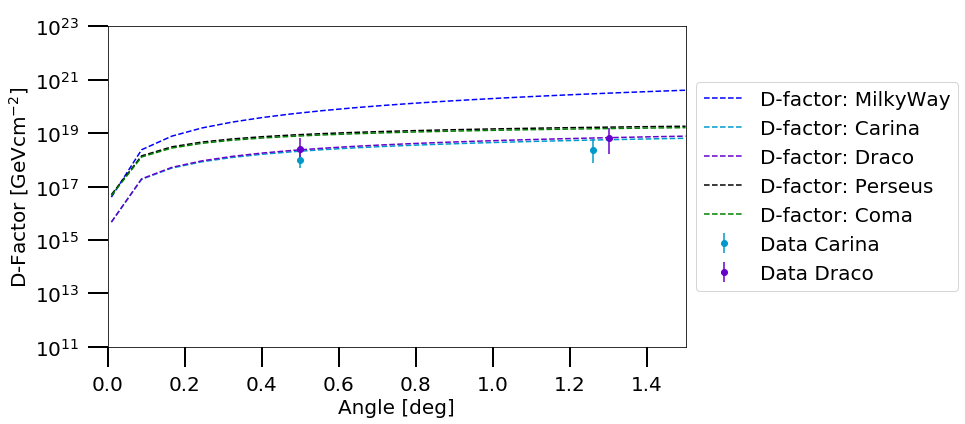

In [19]:
# Plot D-factors for different types of sources
obj_names = ["MilkyWay", "Carina", "Draco","Perseus","Coma"]
plot_dwarf_galaxies(objects=obj_names, profile_type="NFW", max_angle=1.5, nof_evals=20, d_factor=True)

Processing MilkyWay...


C:\Users\Iris\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
C:\Users\Iris\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


Processing Carina...
Processing Draco...
Processing Perseus...
Processing Coma...


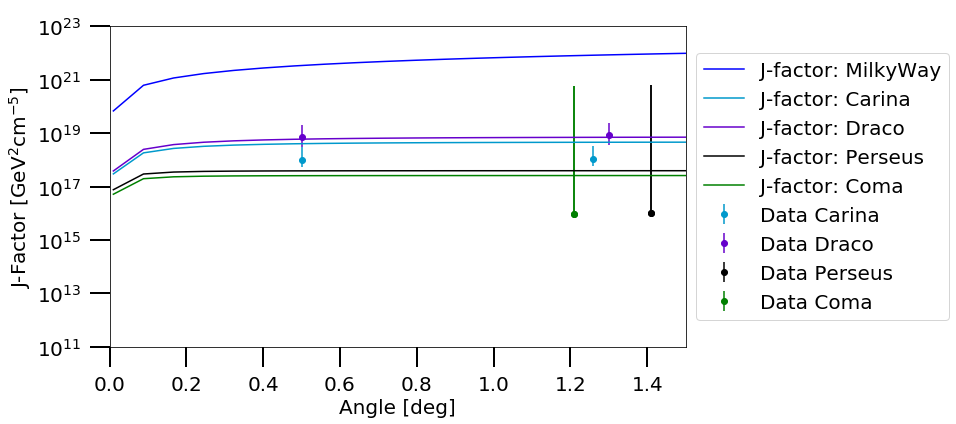

In [20]:
# Plot J-factors for different types of sources
obj_names = ["MilkyWay", "Carina", "Draco","Perseus","Coma"]
plot_dwarf_galaxies(objects=obj_names, profile_type="NFW", max_angle=1.5, nof_evals=20, d_factor=False)

Looking at the above plots for the J- of different sources, we see that values get lower, the more distant a source is situated, which is precisely the behaviour one expects to observe. The J-factor datapoints found in the literature agree more or less with the derived curves. However, in the case of the dwarf galaxy Carina, there still seems to be a slight discrepancy. This is most likely due to uncertainties in the scale density and scale radius used within the derivation. 
Furthermore, note that the 1$\sigma$ error bars for the galaxy clusters, taken from Hektor et al. (2013), who estimated the $2\sigma$ error bars at $^{+60\%}_{-40\%}$, are very high due to the large uncertainties in the cosmological parameters and densities involved in their calculation.

Concerning the plot for the D-factor behaviour, we see that the galaxy clusters yield higher values than the spheroidal dwarf galaxies. 